In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dense, Dropout, Conv1D, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

In [31]:
df_train= pd.read_csv(r"C:\Users\91758\Downloads\Identify_Sentiment\train.csv")

In [32]:
df_train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [33]:
s= df_train.shape[0]
s

7920

In [34]:
df_train['tweet'][0]

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

In [45]:
df_test= pd.read_csv(r"C:\Users\91758\Downloads\Identify_Sentiment\test.csv")
df_test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [46]:
n= df_test.shape[0]
n

1953

In [47]:
df= pd.concat([df_train, df_test])
df.head()

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...


In [48]:
#remove username starting with @
df['clean_tweet']= df['tweet'].replace(r'@\w+','',regex=True)

In [49]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"n\'t", "n not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#remove apostrphe from the word
df['clean_tweet']= [decontracted(i) for i in df['clean_tweet']]

In [50]:
#remove RT(retweet) 
df['clean_tweet'].replace('RT','',regex=True, inplace= True)

# Removing the links present in our clean text 
df['clean_tweet'].replace('((www\.[^\s]+)|(https?://[^\s]+))', '', inplace=True, regex=True)

#Removing # from words
df['clean_tweet']= df['clean_tweet'].replace(r'#','',regex=True)

# Removing special characters, numbers, punctuations as none of them would add any value while making sentiment analysis
#df['clean_tweet']= df['clean_tweet'].apply(lambda x : ' '.join(c for c in x.split() if c not in punctuation))
df['clean_tweet'].replace('[^a-zAA-Z]+', ' ', inplace=True, regex=True)

# Converting all the clean_text column into lower case
df['clean_tweet'] = df['clean_tweet'].str.lower()

In [51]:
#Code for removing slang words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food', 'u':'you'
    } ## Need a huge dictionary

df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

In [52]:
df['clean_tweet'].head()

0    fingerprint pregnancy test android apps beauti...
1    finally a transparant silicon case thanks to m...
2    we love this would you go talk makememories un...
3    i am wired i know i am george i was made that ...
4    what amazing service apple will not even talk ...
Name: clean_tweet, dtype: object

In [53]:
# TOKENIZATION
# Splitting each row of clean_text column into list of words
df['clean_tweet'] = df['clean_tweet'].str.split()

# Doing Lemmatization through WordNetLemmatizer
w_n_lemmatizer = WordNetLemmatizer()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: [w_n_lemmatizer.lemmatize(item) for item in x])

# Joining all the tokens into a string
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join(x))

df['clean_tweet']

0       fingerprint pregnancy test android apps beauti...
1       finally a transparant silicon case thanks to m...
2       we love this would you go talk makememories un...
3       i am wired i know i am george i wa made that w...
4       what amazing service apple will not even talk ...
5       iphone software update fucked up my phone big ...
6       happy for u instapic instadaily u sony xperia ...
7       new type c charger cable uk bay amazon etsy ne...
8       bout to go shopping again listening to music i...
9       photo fun selfie pool water sony camera picoft...
10      hey apple when you make a new ipod dont make i...
11      ha not heavy machinery but it doe what i need ...
12      contemplating giving in to the iphone bandwago...
13      i just made another crazy purchase lol my theo...
14      the battery is so painful i charge it overnigh...
15      from deepellum towards downtown dallas bigd sa...
16      like and share if you want this d phone case f...
17      go cra

In [55]:
sv= int(s*0.2)
sb= s-sv
sb

6336

In [56]:
train= df[:sb]
val= df[sb:-n]
test= df[-n:]

In [57]:
train['label']= train['label'].apply(lambda x: int(x))
val['label']= val['label'].apply(lambda x: int(x))

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
train.head()

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to m...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this would you go talk makememories un...
3,4,0,I'm wired I know I'm George I was made that wa...,i am wired i know i am george i wa made that w...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple will not even talk ...


Normal words


(-0.5, 799.5, 499.5, -0.5)

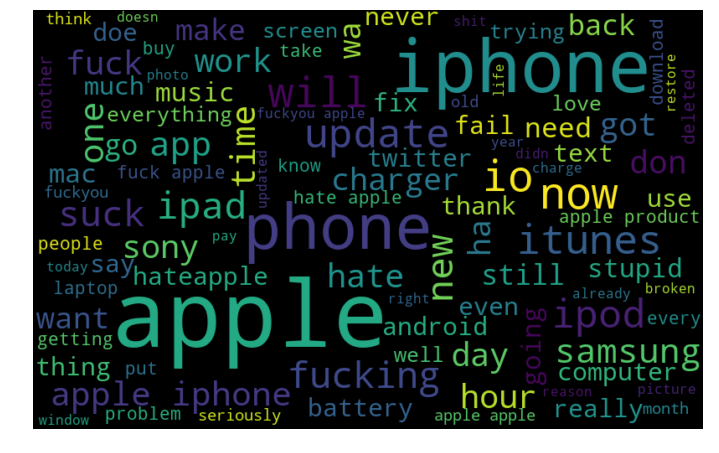

In [60]:
normal_words = ' '.join([word for word in df['clean_tweet'][df['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

Normal words


(-0.5, 799.5, 499.5, -0.5)

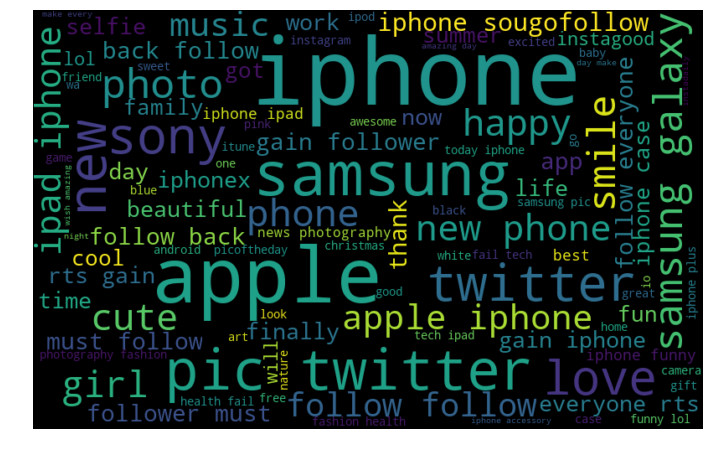

In [61]:
normal_words = ' '.join([word for word in df['clean_tweet'][df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

In [66]:
VOCAB_SIZE = 20000
MAX_LEN = 90


tweet_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tweet_tokenizer.fit_on_texts(train['clean_tweet'].values)

x_train_seq = tweet_tokenizer.texts_to_sequences(train['clean_tweet'].values)
x_val_seq = tweet_tokenizer.texts_to_sequences(val['clean_tweet'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

In [67]:
x_train.shape

(6336, 90)

#RNN with LSTM
max_fatures = 30000
embed_dim = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = x_train.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(1,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

#RNN with LSTM
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = x_train.shape[1], dropout=0.2))
#Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

#Recurrent layer
model.add(LSTM(lstm_out, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

#Fully connected layer
model.add(Dense(64, activation='relu'))

#Dropout for regularization
model.add(Dropout(0.5))

#Output layer
model.add(Dense(1, activation='softmax'))

#Compile the model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

In [91]:
# Model Parameters - You can play with these

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250
EMBEDDING_DIM = 40
BATCH_SIZE = 32
EPOCHS = 3

# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 90, 40)            800000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 250)           30250     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 25

In [ ]:
BATCH_SIZE= 32
EPOCHS= 50

model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=2)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(x_val)

Epoch 1/50
 - 8s - loss: 0.0047 - accuracy: 0.9986
Epoch 2/50
 - 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 3/50
 - 8s - loss: 0.0024 - accuracy: 0.9992
Epoch 4/50
 - 8s - loss: 0.0024 - accuracy: 0.9987
Epoch 5/50
 - 7s - loss: 0.0024 - accuracy: 0.9989
Epoch 6/50
 - 8s - loss: 0.0027 - accuracy: 0.9986
Epoch 7/50
 - 7s - loss: 0.0013 - accuracy: 0.9992
Epoch 8/50
 - 8s - loss: 0.0018 - accuracy: 0.9989
Epoch 9/50
 - 8s - loss: 0.0018 - accuracy: 0.9991
Epoch 10/50
 - 8s - loss: 0.0016 - accuracy: 0.9992
Epoch 11/50
 - 8s - loss: 0.0013 - accuracy: 0.9994
Epoch 12/50
 - 8s - loss: 0.0014 - accuracy: 0.9989
Epoch 13/50
 - 7s - loss: 0.0016 - accuracy: 0.9987
Epoch 14/50
 - 7s - loss: 0.0015 - accuracy: 0.9991
Epoch 15/50
 - 8s - loss: 0.0021 - accuracy: 0.9991
Epoch 16/50
 - 8s - loss: 0.0062 - accuracy: 0.9975
Epoch 17/50
 - 8s - loss: 0.0049 - accuracy: 0.9979
Epoch 18/50
 - 8s - loss: 0.0035 - accuracy: 0.9984
Epoch 19/50
 - 8s - loss: 0.0030 - accuracy: 0.9986
Epoch 20/50
 - 7s - l

In [94]:
cnf_matrix = confusion_matrix(pred, y_val)
cnf_matrix

array([[1051,  109],
       [ 140,  284]], dtype=int64)

In [95]:
#test data
x_test_seq = tweet_tokenizer.texts_to_sequences(test['clean_tweet'].values)

x_test = sequence.pad_sequences(x_test_seq, maxlen=MAX_LEN, padding="post", value=0)

In [96]:
pred1 = model.predict_classes(x_test)

In [97]:
l=[]
for sublist in pred1:
    for item in sublist:
        l.append(item)

In [98]:
p= pd.Series(l)

In [99]:
a= pd.concat([test['id'], p], axis=1)
a.columns=['id', 'label']

In [100]:
a.to_csv(r"C:\Users\91758\Downloads\Identify_Sentiment\solution.csv", index= False)

In [101]:
a.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,0
